# Temporal Fluctuations

Neural oscillations are temporally variable, which can impact measures and interpretations.

### Issue

Neural oscillations are often variable through time (bursty). 

This can exhibit can exhibit as power differences, if temporal variability is not considered and addressed.

### Solution

If and when oscillations are or may be bursty, burst detection can be used to identify times in which the oscillation is present. 

This can be used to restrict analyses to segments in which the oscillation is present, upon which measures of interest can be computed. 

### Related Work

The following papers include discussion of this topic:
- [The rate of transient beta frequency events predicts behavior across tasks and species](https://doi.org/10.7554/eLife.29086.001), Shin et al, 2017
- [Dissecting Transient Burst Events](https://doi.org/10.1016/j.tics.2020.07.004), Zich et al, 2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

from fooof.plts.spectra import plot_spectra_shading
from fooof.utils import trim_spectrum

from neurodsp.sim import sim_powerlaw, sim_bursty_oscillation
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time
from neurodsp.burst import detect_bursts_dual_threshold
from neurodsp.utils import create_times, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_bursts

In [2]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import make_osc_def
from plts import plot_bar, plot_spectrogram, style_psd, savefig
from settings import ALPHA_COLOR, ALPHA_RANGE, COND_COLORS

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Define general simulation settings
n_seconds = 100
fs = 1000

times = create_times(n_seconds, fs)

In [6]:
# Set the function for averaging
avg_func = np.nanmean

In [7]:
# Define parameters for the simulations
cf = 10
exp = -1.0
ap_filt = (1.5, 50)

# Define params for probabilistiic bursting
enter_lo = 0.2
leave_lo = 0.4
enter_hi = 0.4
leave_hi = 0.2

In [8]:
# Analysis settings
nperseg = 1*fs

In [9]:
# Define frequency ranges of interest
psd_range = [2, 40]

In [10]:
# Define some plot settings
plt_kwargs = {'xlabel' : '', 'ylabel' : ''}
labels = ['low-burst', 'high-burst']
leg_size = 22
C1, C2 = COND_COLORS

In [11]:
# Set whether to save out figures
SAVE_FIG = False

### Simulate Time Series

For this comparison, we will simulate and compare two example signals. 

Each time series will contain a bursty alpha oscillation, but the two signals will vary in their burst probability.

In [12]:
# Simulate the aperiodic activity to use for these simulations
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt, variance=0.1)

# Simulate burst oscillation components, with low and high burst probabilities
burst_lo = sim_bursty_oscillation(n_seconds, fs, cf, 'prob', variance=1.,
                                  burst_params={'enter_burst' : enter_lo, 'leave_burst' : leave_lo})
burst_hi = sim_bursty_oscillation(n_seconds, fs, cf, 'prob', variance=1., 
                                  burst_params={'enter_burst' : enter_hi, 'leave_burst' : leave_hi})

In [13]:
# Combine the aperiodic and periodic components of the simulations
sig_lo = ap + burst_lo
sig_hi = ap + burst_hi

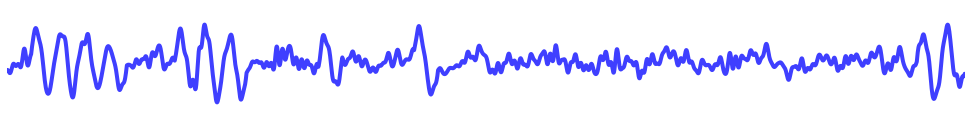

In [14]:
# Plot the low burst probability signal
plot_time_series(times, sig_lo, xlim=[1, 5], alpha=0.75, colors=C1, lw=4)
plt.axis('off')
savefig(SAVE_FIG, '04-burst_high')

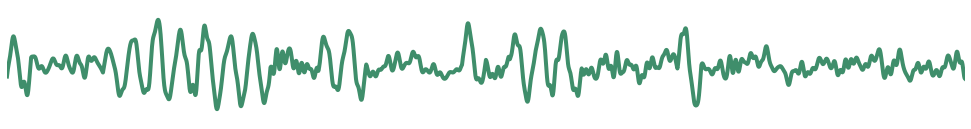

In [15]:
# Plot the high burst probability signal
plot_time_series(times, sig_hi, xlim=[1, 5], alpha=0.75, colors=C2, lw=4)
plt.axis('off')
savefig(SAVE_FIG, '04-burst_low')

### Compare the Power Spectra

Next, let's compare the power spectra of the two example signals.

In [16]:
# Compute power spectra of each signal
freqs, powers_lo = trim_spectrum(*compute_spectrum(sig_lo, fs, nperseg=nperseg), psd_range)
freqs, powers_hi = trim_spectrum(*compute_spectrum(sig_hi, fs, nperseg=nperseg), psd_range)

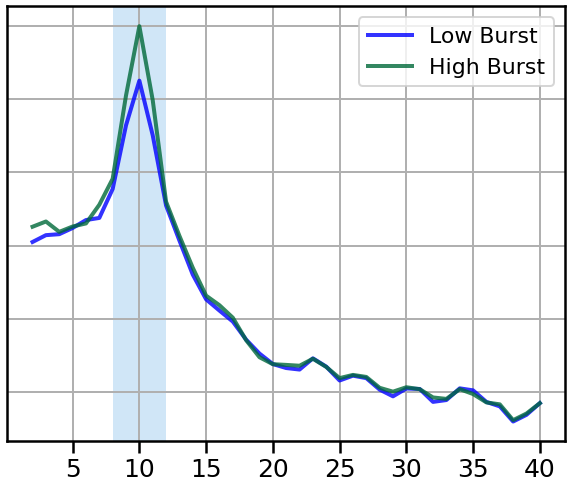

In [17]:
# Plot the power spectra, comparing between signals
plot_spectra_shading(freqs, [powers_lo, powers_hi], ALPHA_RANGE,
                     labels=['Low Burst', 'High Burst'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=COND_COLORS, line_alpha=0.8)
plt.legend(prop={'size': leg_size})
savefig(SAVE_FIG, '04-burst_psd')

Based simply on the power spectra, it looks like our two signals have a clear difference in alpha power. 

### Apply Burst Detection

By construction, we know our simulated signals have temporal variability in their oscillations. 

To dig into this, let's apply burst detection to try and measure when, in time, the oscillations are present. 

Note: here we are using burst detection using the 
[dual-amplitude](https://neurodsp-tools.github.io/neurodsp/auto_tutorials/burst/plot_BurstDetection.html)
algorithm.

In [18]:
# Apply burst detection to the low burst probability signal
bursting_lo = detect_bursts_dual_threshold(sig_lo, fs, (1., 1.), ALPHA_RANGE)

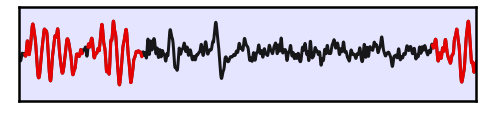

In [19]:
# Plot a segment of burst detection on the first signal
_, ax = plt.subplots(figsize=(8, 2.5))
plot_bursts(times, sig_lo, bursting_lo, xlim=[1, 5], **plt_kwargs, alpha=[0.9, 0.9], ax=ax)
plt.xticks([]); plt.yticks([]);
ax.axvspan(1, 5, color=C1, alpha=0.1, lw=0)
savefig(SAVE_FIG, '04-burst_det1')

In [20]:
# Apply burst detection to the high burst probability signal
bursting_hi = detect_bursts_dual_threshold(sig_hi, fs, (0.4, 1), ALPHA_RANGE)

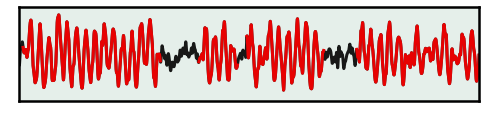

In [21]:
# Plot a segment of burst detection on the first signal
xlim = [5, 10]
_, ax = plt.subplots(figsize=(8, 2.5))
plot_bursts(times, sig_hi, bursting_hi, xlim=xlim, **plt_kwargs, alpha=[0.9, 0.9], ax=ax)
plt.xticks([]); plt.yticks([]);
ax.axvspan(*xlim, color=C2, alpha=0.1, lw=0)
savefig(SAVE_FIG, '04-burst_det2')

In the above we can see, as expected the two signals differ in the prominence of the bursting.

### Compare Oscillatory Power

Now that we have identified the bursts, we can compare the power of the oscillation across the whole signal, to the power of the oscillations during moments of bursting. 

In [22]:
# Calculate instantaneous amplitude of each signal
amp_lo = amp_by_time(sig_lo, fs, ALPHA_RANGE)
amp_hi = amp_by_time(sig_hi, fs, ALPHA_RANGE)

In [23]:
# Check the difference in power, across the whole signal
print('Low  Burst Signal - total power : {:1.2f}'.format(avg_func(amp_lo)))
print('High Burst Signal - total power : {:1.2f}'.format(avg_func(amp_hi)))

Low  Burst Signal - total power : 0.55
High Burst Signal - total power : 0.94


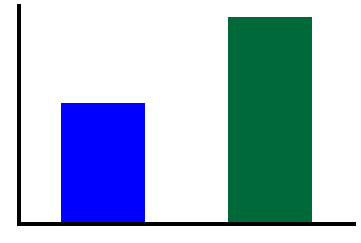

In [24]:
# Plot the comparison of total power between signals
plot_bar(amp_lo, amp_hi, [], color=COND_COLORS, width=0.5)
savefig(SAVE_FIG, '04-bar_oscpow')

In [25]:
# Check the difference in power, for identified burst segments
print('Low  Burst Signal - burst power : {:1.2f}'.format(avg_func(amp_hi[bursting_lo])))
print('High Burst Signal - burst power : {:1.2f}'.format(avg_func(amp_hi[bursting_hi])))

Low  Burst Signal - burst power : 1.03
High Burst Signal - burst power : 1.21


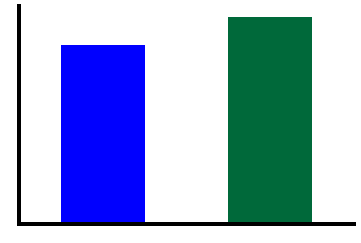

In [26]:
# Plot the comparison of burst power between signals
plot_bar(amp_lo[bursting_lo], amp_hi[bursting_hi], [],
         color=COND_COLORS, width=0.5)
savefig(SAVE_FIG, '04-bar_burstpow')

## Aspects of Temporal Variability

As we've seen above, oscillations can be temporally variable, impacting power measures. 

In the following, we will examine 3 ways in which bursts can vary:
- burst duration (short vs. long bursts)
- burst occurence (common vs. rare bursts)
- burst amplitude (the amplitude of the oscillation within the bursts)

In [27]:
# Settings for this series of plots: xlims
st = 1.5
xlim = [st, st+3]

### Short vs Long Bursts

Here, we will simulate and compare bursts with a short vs. long burst length.

In [28]:
# Make short bursts
burst_params = {'n_cycles_burst' : 3, 'n_cycles_off' : 6}
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params)
short_bursts = ap + bursts

# Make long bursts
burst_params = {'n_cycles_burst' : 5, 'n_cycles_off' : 4}
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params)
long_bursts = ap + bursts

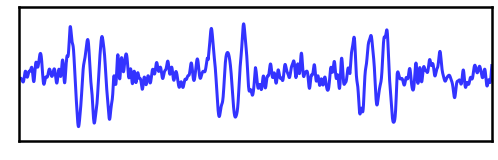

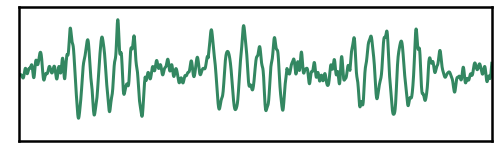

In [29]:
# Plot the time series comparing bursts of different durations
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, short_bursts, xlim=xlim, 
                 colors=C1, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_duration_low')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, long_bursts, xlim=xlim, 
                 colors=C2, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_duration_high')

In [30]:
# Compute power spectra of burst with different burst durations
freqs1, powers1 = trim_spectrum(*compute_spectrum(short_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(long_bursts, fs, nperseg=nperseg), psd_range)

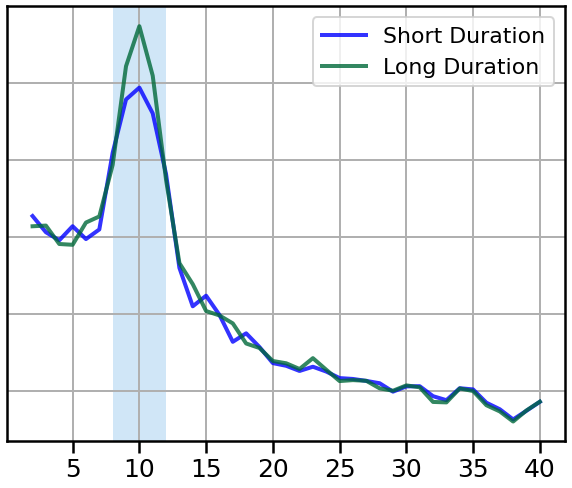

In [31]:
# Plot power spectra comparing bursts with different durations
plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Short Duration', 'Long Duration'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=COND_COLORS, line_alpha=0.8)
plt.legend(prop={'size': leg_size})
savefig(SAVE_FIG, '04-psd_burst_duration')

### Burst Occurence

Here, we will simulate and compare bursts with a low vs. high occurence.

In [32]:
# Make low occurence bursts
burst_params = {'n_cycles_burst' : 3, 'n_cycles_off' : 17}
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params)
low_oc_bursts = ap + bursts

# Make high occurence bursts
burst_params = {'n_cycles_burst' : 3, 'n_cycles_off' : 7}
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params)
high_oc_bursts = ap + bursts

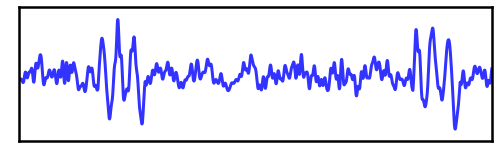

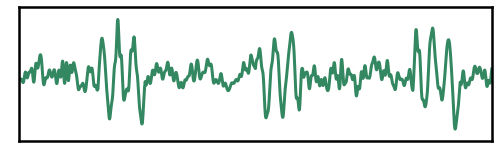

In [33]:
# Plot the time series comparing bursts of different occurences
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, low_oc_bursts, xlim=xlim, 
                 colors=C1, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_occurence_low')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, high_oc_bursts, xlim=xlim, 
                 colors=C2, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_occurence_high')

In [34]:
# Compute power spectra of burst with different burst occurence
freqs1, powers1 = trim_spectrum(*compute_spectrum(low_oc_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(high_oc_bursts, fs, nperseg=nperseg), psd_range)

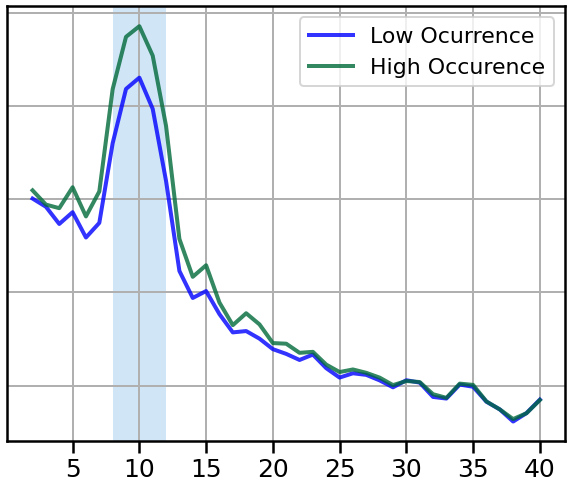

In [35]:
# Plot power spectra comparing bursts with different occurences
plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Low Ocurrence', 'High Occurence'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=COND_COLORS, line_alpha=0.8)
plt.legend(prop={'size': leg_size})
savefig(SAVE_FIG, '04-psd_burst_occurence')

### Change Burst Amplitude

Here, we will simulate and compare bursts with a low vs. high burst amplitude.

In [36]:
# Define burst parameters for bursts with changes in amplitude
burst_params = {'n_cycles_burst' : 3, 'n_cycles_off' : 7}

# Make low amplitude bursts
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params, variance=1.)
low_amp_bursts = ap + bursts

# Make high amplitude bursts
bursts = sim_bursty_oscillation(n_seconds, fs, cf, 'durations', burst_params, variance=2.25)
high_amp_bursts = ap + bursts

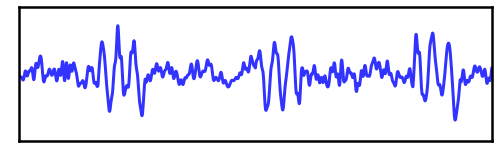

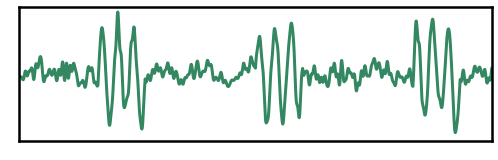

In [37]:
# Plot the time series comparing bursts of different amplitudes
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, low_amp_bursts, xlim=xlim, ylim=[-3, 3],
                 colors=C1, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_amp_low')

_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, high_amp_bursts, xlim=xlim, ylim=[-3.1, 3.1],
                 colors=C2, alpha=0.8, **plt_kwargs, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
savefig(SAVE_FIG, '04-ts_burst_amp_high')

In [38]:
# Compute power spectra of burst with different burst amplitudes
freqs1, powers1 = trim_spectrum(*compute_spectrum(low_amp_bursts, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(high_amp_bursts, fs, nperseg=nperseg), psd_range)

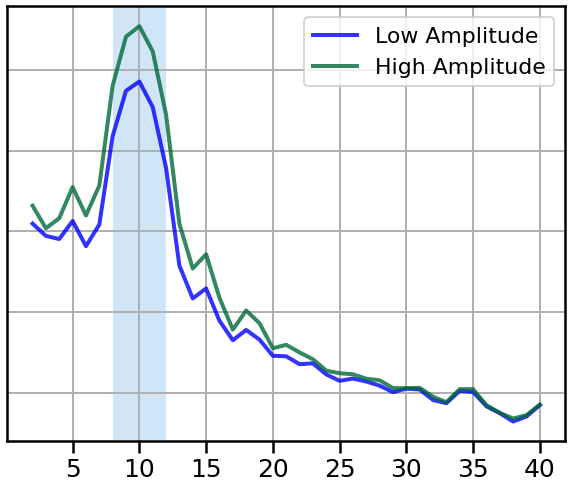

In [39]:
# Plot power spectra comparing bursts with different amplitudes
plot_spectra_shading(freqs1, [powers1, powers2], [8, 12],
                     labels=['Low Amplitude', 'High Amplitude'],
                     log_freqs=False, log_powers=True,
                     lw=4, shade_colors=ALPHA_COLOR)
style_psd(plt.gca(), line_colors=COND_COLORS, line_alpha=0.8)
plt.legend(prop={'size': leg_size})
savefig(SAVE_FIG, '04-psd_burst_amplitude')

## Time-Resolved Measures

In the above, we looked at average power measures, using power spectra. 

Here, we will explore time-resolved measures of oscillations, and see how they can interact with temporal variability of oscillations. 

In [40]:
# Local settings
ns = 3          # Number of seconds for these simulations
n_off1 = 10     # Number of cycles off, at the start
bl = 7          # Burst length
n_off2 = 10     # Number of cycles off, at the end

# Set the frequency limit for plotting spectrograms
flim = 8        # The 8th index, which is about frequency of 25

In [41]:
# Create a burst definition for the specified 
osc_def = make_osc_def(n_off1, bl, n_off2)
burst = sim_bursty_oscillation(ns, fs, cf, osc_def)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/sim/periodic.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if burst_def == 'prob' and burst_param not in burst_params:


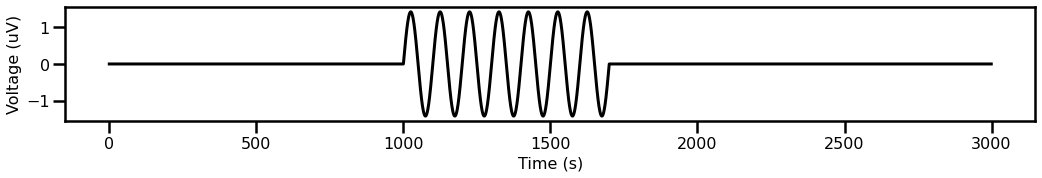

In [42]:
# Plot the simulated burst signal
plot_time_series(np.arange(0, len(burst)), burst)

In [43]:
# Compute spectrogram of the above simulated signal
freqs, tt, pxx = spectrogram(burst, fs, window='hann', nperseg=int(0.3*fs))

In [44]:
# Remap times vector to simulate a trial structure
spg_times = np.arange(-2.5, 0.5, (1/len(tt)))

# Check the selected frequency range
print('Upper limit freq range: {:4.2f}'.format(freqs[flim]))

Upper limit freq range: 26.67


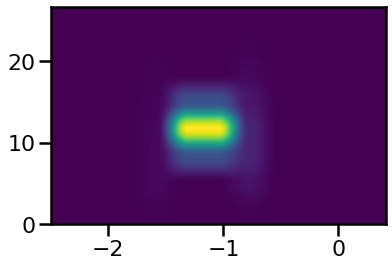

In [45]:
# Plot a spectrogram of the burst time series
plot_spectrogram(spg_times, freqs, pxx, flim)

In the above we can see that, the burst activity arises as a peak at a specific frequency and moment in time. 

### Bursts Across Time

In the next analysis, we will simulate 'trials' (individual time segments with a burst), with variable burst timing, to examine what might happen within an experiment in which oscillatory activity is bursty, but variable (in time) across trials. 

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/sim/periodic.py:157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if burst_def == 'prob' and burst_param not in burst_params:


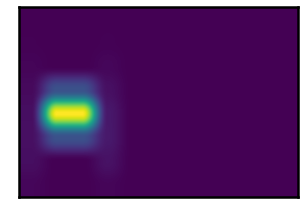

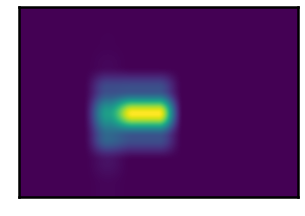

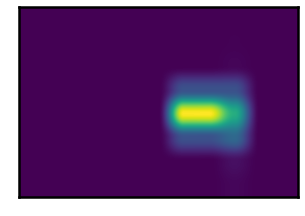

In [46]:
# Simulate some example 'trials', with different burst onset times
n_off1s = [2, 9, 16]
for ind, n_off1 in zip(range(len(n_off1s)), n_off1s):
        
    osc_def = make_osc_def(n_off1, bl, n_off1)
    burst = sim_bursty_oscillation(ns, fs, cf, osc_def)
    
    freqs, tt, pxx = spectrogram(burst, fs, window='hann', nperseg=int(0.3*fs))
    
    plot_spectrogram(spg_times, freqs, pxx, flim, True, figsize=(5, 3.5))
    savefig(SAVE_FIG, '04-indi_spectrogram_' + str(ind))

In the above, we simulated example 'trials', with bursts at different points in time.

Next, we can systematically simulate across these 'trials', and see what the average spectrogram looks like.

In [47]:
# Simulate bursts across trials, and average
pxxs = []
starts = np.arange(2, 25, 2)
for bs in starts:
    
    osc_def = make_osc_def(bs, bl, n_off2)
    bt = sim_bursty_oscillation(ns, fs, cf, osc_def)
    
    _, _, pxx = spectrogram(bt, fs, window='hann', nperseg=int(0.3*fs))
    pxxs.append(pxx)
    
# Average together spectrograms
avg_pxx = np.array(pxxs).mean(0)

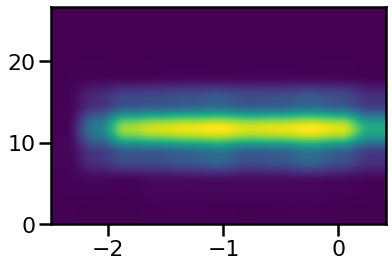

In [48]:
# Plot the average spectrogram
plot_spectrogram(spg_times, freqs, avg_pxx, flim)
savefig(SAVE_FIG, '04-avg_spectrogram')

As we can see, in the above average spectrogram, the activity looks to be sustained over the entire trial segment. 

However, we know that this is an averaging artifact - there was no consistent activity in any individual trial. 

This average reflects the variaiblity in timing across trials, but does not itself imply a sustained oscillation.

### Conclusions

In the above, we saw that the two simulated signals appeared to have different amounts of alpha power. 

Note that a common interpretation of a change in power is often that the magnitude of the oscillations has changed. 

In this scenario, that would be an inaccurate interpretation. 

As we can see from applying burst detection, the power of the oscillations _when they are present_ is equal. 

This shows how differences in temporal variability can look like power differences. 

Applying burst detection can help address this potential issue. 

As well as being important to check as a control, temporal variability itself may be an interest measure of interest. 